# Import 

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.metrics.pairwise import cosine_similarity

In [3]:
model = "dinov2_g"
base_path = Path("/projects/synsight/data/jump_embeddings/wells_embeddings/dinov2_g/")
parquet_metadata = base_path / model / Path("metadata.parquet")
jump_df_well = pd.read_parquet(parquet_metadata)
embeddings_path = base_path / model / "Embeddings__ZCA_C__Int.npy"
X_well = np.load(embeddings_path)

In [4]:
X_well.shape

(745884, 1536)

In [6]:
jump_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112480 entries, 0 to 112479
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Metadata_InChI_ID  112480 non-null  int64 
 1   Metadata_JCP2022   112480 non-null  object
 2   Metadata_InChI     112480 non-null  object
 3   Metadata_Is_dmso   112480 non-null  bool  
dtypes: bool(1), int64(1), object(2)
memory usage: 2.7+ MB


# Plots


In [7]:
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from typing import Literal, Tuple


def _coerce_bool_col(s: pd.Series) -> np.ndarray:
    v = s.astype(str).str.strip().str.lower()
    return v.isin({"1", "true", "t", "yes", "y"})


def _l2norm(X: np.ndarray, eps: float = 1e-12) -> np.ndarray:
    n = np.maximum(np.linalg.norm(X, axis=1, keepdims=True), eps)
    return X / n


def _ap_from_scores(scores: np.ndarray, is_pos: np.ndarray) -> float:
    # sort by descending score
    order = np.argsort(-scores, kind="mergesort")
    pos_at_k = is_pos[order]
    n_pos = int(pos_at_k.sum())
    if n_pos == 0:
        return np.nan
    hits = np.flatnonzero(pos_at_k)  # 0-based ranks where positives occur
    precs = [(i + 1) / (r + 1) for i, r in enumerate(hits)]
    return float(np.mean(precs))


def map_for_n_compounds(
    jump_df_well: pd.DataFrame,
    X_well: np.ndarray,
    *,
    compound_col: str = "Metadata_JCP2022",
    is_dmso_col: str = "Metadata_Is_dmso",
    plate_col: str = "Metadata_Plate",
    n_compounds: int = 200,
    gallery_mode: Literal["dmso_only", "all_others", "non_dmso_others"] = "dmso_only",
    restrict_within_plate: bool = False,
    similarity: Literal["cosine", "neg_euclidean"] = "cosine",
    n_jobs: int = -1,
    random_state: int = 0,
) -> Tuple[float, pd.DataFrame]:
    """
    Compute mAP over queries belonging to a random subset of n_compounds.
    Positives = other wells of the same compound (excluding the query).
    Negatives per gallery_mode (default: DMSO only).

    Returns:
      mAP (float), per_query_ap DataFrame with columns:
      ['index','compound','plate','n_pos','n_gallery','AP']
    """
    assert len(jump_df_well) == X_well.shape[0], "Embeddings and DF must align."

    idx = jump_df_well.index.to_numpy()
    comp_ids = jump_df_well[compound_col].astype(str).values
    plates = jump_df_well[plate_col].astype(str).values
    is_dmso = _coerce_bool_col(jump_df_well[is_dmso_col]).values

    # pick n_compounds among NON-DMSO compounds that have at least 2 wells
    df_non = jump_df_well.loc[~is_dmso, [compound_col]]
    counts = df_non[compound_col].value_counts()
    pool = counts[counts >= 2].index.to_numpy()
    if pool.size == 0:
        return np.nan, pd.DataFrame(
            columns=["index", "compound", "plate", "n_pos", "n_gallery", "AP"]
        )
    rng = np.random.default_rng(random_state)
    chosen = rng.choice(pool, size=min(n_compounds, pool.size), replace=False)

    # queries = all wells whose compound is in 'chosen' (and not DMSO)
    query_mask = (~is_dmso) & np.isin(comp_ids, chosen)
    query_indices = np.flatnonzero(query_mask)
    if query_indices.size == 0:
        return np.nan, pd.DataFrame(
            columns=["index", "compound", "plate", "n_pos", "n_gallery", "AP"]
        )

    # similarity prep
    if similarity == "cosine":
        Xp = _l2norm(X_well.astype(np.float32, copy=False))
    else:  # neg_euclidean
        Xp = X_well.astype(np.float32, copy=False)

    # preindex to speed membership tests
    comp_to_idx = {}
    for i, c in enumerate(comp_ids):
        comp_to_idx.setdefault(c, []).append(i)
    plate_to_idx = {}
    for i, p in enumerate(plates):
        plate_to_idx.setdefault(p, []).append(i)

    def _one_query(q: int):
        q_comp, q_plate = comp_ids[q], plates[q]
        # candidate gallery
        if restrict_within_plate:
            cand = np.array(plate_to_idx[q_plate], dtype=int)
        else:
            cand = np.arange(len(Xp), dtype=int)
        cand = cand[cand != q]  # remove query itself

        # positives among candidates
        pos_set = set(comp_to_idx.get(q_comp, [])) - {q}

        # gallery filter by mode
        if gallery_mode == "dmso_only":
            keep = np.array([i in pos_set or is_dmso[i] for i in cand], dtype=bool)
        elif gallery_mode == "all_others":
            keep = np.ones_like(cand, dtype=bool)
        else:  # non_dmso_others
            keep = np.array(
                [i in pos_set or (not is_dmso[i]) for i in cand], dtype=bool
            )

        G = cand[keep]
        if G.size == 0:
            return None

        is_pos = np.array([i in pos_set for i in G], dtype=bool)
        n_pos = int(is_pos.sum())
        if n_pos == 0:
            return None

        if similarity == "cosine":
            scores = Xp[G] @ Xp[q]
        else:
            diff = Xp[G] - Xp[q]
            d = np.sqrt(np.maximum(np.sum(diff * diff, axis=1), 0.0))
            scores = -d  # higher is better

        ap = _ap_from_scores(scores, is_pos)
        return {
            "index": idx[q],
            "compound": q_comp,
            "plate": q_plate,
            "n_pos": n_pos,
            "n_gallery": int(G.size),
            "AP": ap,
        }

    rows = Parallel(n_jobs=n_jobs, prefer="threads")(
        delayed(_one_query)(int(q)) for q in tqdm(query_indices)
    )
    rows = [r for r in rows if r is not None]
    per_query_ap = pd.DataFrame(
        rows, columns=["index", "compound", "plate", "n_pos", "n_gallery", "AP"]
    )
    mAP = float(per_query_ap["AP"].mean()) if not per_query_ap.empty else np.nan
    return mAP, per_query_ap

In [8]:
from typing import Literal, Tuple, Iterable, Optional
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from tqdm.auto import tqdm


def map_for_compound_list_restricted_dmso(
    jump_df_well: pd.DataFrame,
    X_well: np.ndarray,
    *,
    include_compounds: Iterable[
        str
    ],  # <-- REQUIRED: list/iterable of Metadata_JCP2022 IDs to evaluate
    compound_col: str = "Metadata_JCP2022",
    is_dmso_col: str = "Metadata_Is_dmso",
    plate_col: str = "Metadata_Plate",
    n_compounds: Optional[
        int
    ] = None,  # cap how many from include_compounds (None = use all)
    similarity: Literal["cosine", "neg_euclidean"] = "cosine",
    n_jobs: int = -1,
    random_state: int = 0,
    exclude_top_k: int = 8,  # exclude the top-k by replicate count (within include_compounds)
) -> Tuple[float, pd.DataFrame]:
    """
    mAP over queries restricted to a provided list of compounds.
    Positives = other wells of the same compound (excluding the query).
    Negatives = DMSO wells only from the plates where the positives occur.

    Returns:
      mAP (float), per_query_ap DataFrame with columns:
      ['index','compound','plate','n_pos','n_gallery','AP']
    """
    assert len(jump_df_well) == X_well.shape[0], "Embeddings and DF must align."

    include_set = set(map(str, include_compounds))
    if len(include_set) == 0:
        return np.nan, pd.DataFrame(
            columns=["index", "compound", "plate", "n_pos", "n_gallery", "AP"]
        )

    # --- columns
    idx = jump_df_well.index.to_numpy()
    comp_ids = jump_df_well[compound_col].astype(str).values
    plates = jump_df_well[plate_col].astype(str).values
    is_dmso = _coerce_bool_col(
        jump_df_well[is_dmso_col]
    ).values  # assumes you defined this helper

    # --- choose compounds: in include_set, non-DMSO, with >=2 wells
    df_non = jump_df_well.loc[~is_dmso, [compound_col]]
    counts = df_non[compound_col].astype(str).value_counts()

    # restrict counts to include_set
    counts = counts[counts.index.isin(include_set)]
    if counts.empty:
        return np.nan, pd.DataFrame(
            columns=["index", "compound", "plate", "n_pos", "n_gallery", "AP"]
        )

    # exclude top-k by replicate count (within the restricted set)
    if exclude_top_k and exclude_top_k > 0:
        top_k_ids = (
            counts.sort_values(ascending=False)
            .sort_index(kind="mergesort")
            .head(exclude_top_k)
            .index.to_numpy()
        )
    else:
        top_k_ids = np.array([], dtype=str)

    pool = counts[counts >= 2].index.to_numpy()
    pool = pool[~np.isin(pool, top_k_ids)]
    if pool.size == 0:
        return np.nan, pd.DataFrame(
            columns=["index", "compound", "plate", "n_pos", "n_gallery", "AP"]
        )

    # optional cap
    rng = np.random.default_rng(random_state)
    if n_compounds is not None:
        chosen = rng.choice(pool, size=min(int(n_compounds), pool.size), replace=False)
    else:
        chosen = pool

    # queries = all wells whose compound is in 'chosen' (and not DMSO)
    query_mask = (~is_dmso) & np.isin(comp_ids, chosen)
    query_indices = np.flatnonzero(query_mask)
    if query_indices.size == 0:
        return np.nan, pd.DataFrame(
            columns=["index", "compound", "plate", "n_pos", "n_gallery", "AP"]
        )

    # similarity prep
    if similarity == "cosine":
        Xp = _l2norm(
            X_well.astype(np.float32, copy=False)
        )  # assumes you defined this helper
    else:
        Xp = X_well.astype(np.float32, copy=False)

    # preindex
    comp_to_idx = {}
    for i, c in enumerate(comp_ids):
        comp_to_idx.setdefault(c, []).append(i)
    plate_to_idx = {}
    for i, p in enumerate(plates):
        plate_to_idx.setdefault(p, []).append(i)

    def _ap_from_scores(scores: np.ndarray, is_pos: np.ndarray) -> float:
        order = np.argsort(-scores, kind="mergesort")
        pos_at_k = is_pos[order]
        n_pos = int(pos_at_k.sum())
        if n_pos == 0:
            return np.nan
        hits = np.flatnonzero(pos_at_k)
        precs = [(i + 1) / (r + 1) for i, r in enumerate(hits)]
        return float(np.mean(precs))

    def _one_query(q: int):
        q_comp, q_plate = comp_ids[q], plates[q]
        pos_set = set(comp_to_idx.get(q_comp, [])) - {q}
        if not pos_set:
            return None

        # plates where positives live
        pos_plates = set(plates[list(pos_set)])

        # gallery = positives + DMSO from those plates
        cand = list(pos_set)
        for pl in pos_plates:
            cand.extend([i for i in plate_to_idx[pl] if is_dmso[i]])
        cand = np.array(sorted(set(cand)), dtype=int)
        if cand.size == 0:
            return None

        is_pos = np.array([i in pos_set for i in cand], dtype=bool)
        n_pos = int(is_pos.sum())
        if n_pos == 0:
            return None

        if similarity == "cosine":
            scores = Xp[cand] @ Xp[q]
        else:
            diff = Xp[cand] - Xp[q]
            d = np.sqrt(np.maximum(np.sum(diff * diff, axis=1), 0.0))
            scores = -d

        ap = _ap_from_scores(scores, is_pos)
        return {
            "index": idx[q],
            "compound": q_comp,
            "plate": q_plate,
            "n_pos": n_pos,
            "n_gallery": int(cand.size),
            "AP": ap,
        }

    rows = Parallel(n_jobs=n_jobs, prefer="threads")(
        delayed(_one_query)(int(q)) for q in tqdm(query_indices)
    )
    rows = [r for r in rows if r is not None]
    per_query_ap = pd.DataFrame(
        rows, columns=["index", "compound", "plate", "n_pos", "n_gallery", "AP"]
    )
    mAP = float(per_query_ap["AP"].mean()) if not per_query_ap.empty else np.nan
    return mAP, per_query_ap

/projects/synsight/repos/phenoseeker/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
df = pd.read_csv("data/not_in_chembl_lit_pcba.csv")

# extract as list if needed
not_in_chembl_lit_pcba = df["Metadata_JCP2022"].tolist()

In [ ]:
mAP, per_query_ap = map_for_compound_list_restricted_dmso(
    jump_df_well,
    X_well,
    include_compounds=not_in_chembl_lit_pcba,
    n_compounds=None,  # or None to use all in keep_ids (after filters)
    similarity="cosine",
    n_jobs=-1,
    random_state=42,
    exclude_top_k=8,
)
print("mAP:", mAP)
print(per_query_ap.head())

In [ ]:
def random_ap_expectation(n_pos: int, n_gallery: int) -> float:
    if n_pos <= 0 or n_gallery <= 1 or n_pos > n_gallery:
        return np.nan
    H_N = np.sum(1.0 / np.arange(1, n_gallery + 1))  # harmonic number
    exp_ap = (H_N + (n_pos - 1) / (n_gallery - 1) * (n_gallery - H_N)) / n_gallery
    return float(exp_ap)


per_query_ap["random"] = [
    random_ap_expectation(n_pos, n_gallery)
    for n_pos, n_gallery in zip(per_query_ap["n_pos"], per_query_ap["n_gallery"])
]

In [ ]:
# Flag queries above random baseline
per_query_ap["better_than_random"] = per_query_ap["AP"] > per_query_ap["random"]

# Aggregate by compound
compound_summary = (
    per_query_ap.groupby("compound")
    .agg(
        n_queries=("AP", "size"),
        n_better=("better_than_random", "sum"),
    )
    .reset_index()
)

compound_summary["frac_better"] = (
    compound_summary["n_better"] / compound_summary["n_queries"]
)

# Counts of compounds
n_any = (compound_summary["n_better"] >= 1).sum()
n_majority = (compound_summary["frac_better"] >= 0.5).sum()
n_all = (compound_summary["frac_better"] == 1.0).sum()

print(f"Compounds with ≥1 query better than random: {n_any}")
print(f"Compounds with majority queries better than random: {n_majority}")
print(f"Compounds with all queries better than random: {n_all}")

Compounds with ≥1 query better than random: 70627
Compounds with majority queries better than random: 41926
Compounds with all queries better than random: 9131


In [ ]:
import matplotlib.pyplot as plt


def plot_active_compounds_counts(compound_summary):
    n_any = (compound_summary["n_better"] >= 1).sum()
    n_majority = (compound_summary["frac_better"] > 0.5).sum()
    n_all = (compound_summary["frac_better"] == 1.0).sum()

    labels = ["≥1 replicate active", "Majority active", "All active"]
    counts = [n_any, n_majority, n_all]

    fig, ax = plt.subplots(figsize=(6, 4), dpi=150)
    bars = ax.bar(labels, counts, color=["#4c72b0", "#55a868", "#c44e52"], alpha=0.9)

    for bar, c in zip(bars, counts):
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 0.5,
            str(c),
            ha="center",
            va="bottom",
            fontsize=10,
        )

    ax.set_ylabel("Number of compounds")
    ax.set_title("Compounds retrieving replicates better than random")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_active_compounds_counts(compound_summary):
    total = compound_summary.shape[0]

    n_any = (compound_summary["n_better"] >= 1).sum()
    n_majority = (compound_summary["frac_better"] > 0.5).sum()
    n_all = (compound_summary["frac_better"] == 1.0).sum()

    labels = ["≥1 replicate active", "Majority active", "All active"]
    counts = [n_any, n_majority, n_all]
    percents = [100 * c / total for c in counts]

    fig, ax = plt.subplots(figsize=(6, 4), dpi=150)
    bars = ax.bar(labels, percents, color=["#4c72b0", "#55a868", "#c44e52"], alpha=0.9)

    for bar, p, c in zip(bars, percents, counts):
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            p + 0.5,
            f"{p:.1f}%\n(n={c})",  # show both % and absolute n
            ha="center",
            va="bottom",
            fontsize=9,
        )

    ax.set_ylabel("Compounds (%)")
    ax.set_title("Compounds retrieving replicates better than random")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.ylim(0, max(percents) * 1.25)  # add headroom for labels
    plt.tight_layout()
    plt.show()

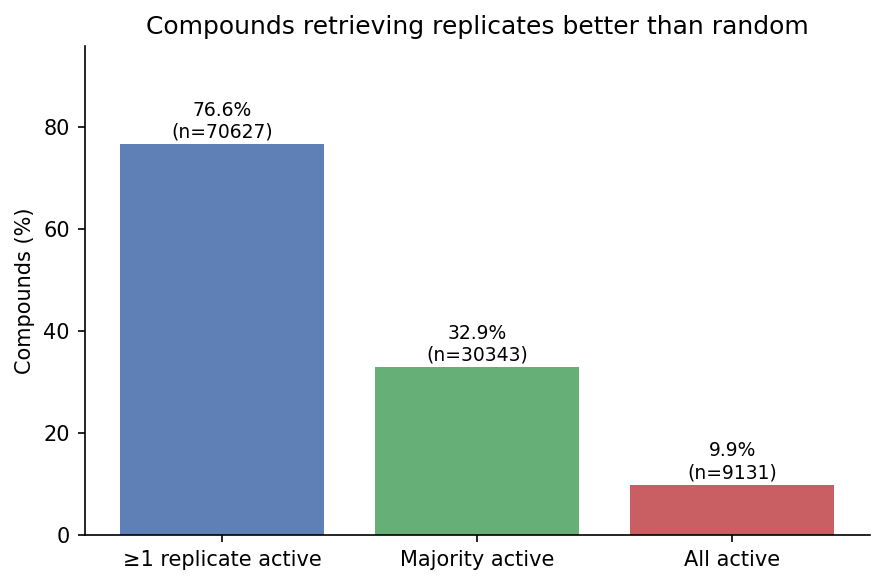

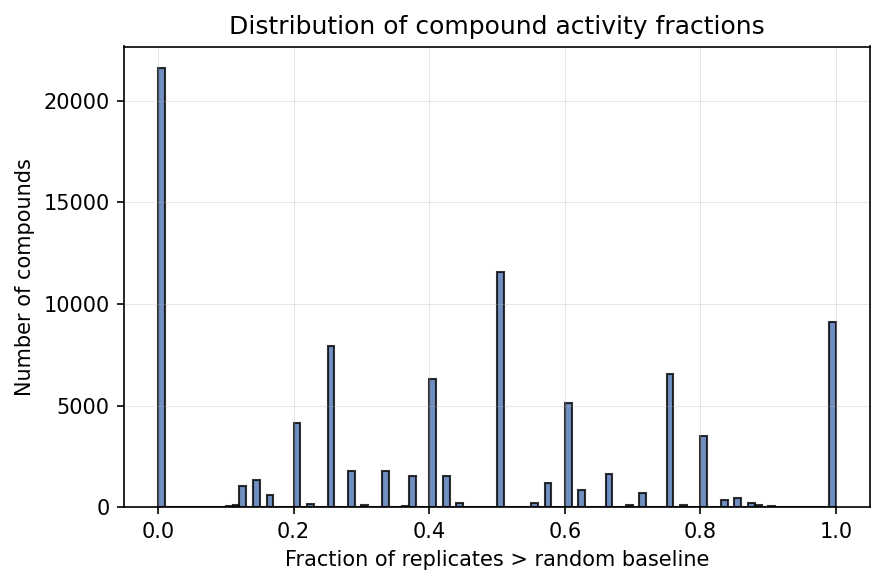

In [ ]:
plot_active_compounds_counts(compound_summary)
